#### Importing the model and getting the output values of the pep-encoder

In [1]:
#samples to plot
N = 1000
#model constants
d_model = 64
d_ff = 512

In [8]:
import torch
import numpy as np
from modelAndPerformances import *
from hyperparametricSelection import hyperparameterSelection

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

n_heads, n_layers, d_k = hyperparameterSelection()
data = pd.read_csv('data/trainDataFull/fullTrainingData.csv')
pep_inputs, hla_inputs, labels, labelsHla = make_data(data, True)

positive_mask = labels == 1
pep_pos = pep_inputs[positive_mask]
hla_pos = hla_inputs[positive_mask]
labels_pos = labels[positive_mask]
labelsHla_pos = labelsHla[positive_mask]

unique_hlas = np.unique(labelsHla_pos)
selected_hlas = np.random.choice(unique_hlas, size=10, replace=False)

hla_mask = np.isin(labelsHla_pos, selected_hlas)
hla_mask = torch.tensor(hla_mask, dtype=torch.bool)

pep_filtered = pep_pos[hla_mask]
hla_filtered = hla_pos[hla_mask]
labels_filtered = labels_pos[hla_mask]
labelsHla_filtered = labelsHla_pos[hla_mask.numpy()]

num_samples = min(100, len(pep_filtered))
indices = torch.randperm(len(pep_filtered))[:num_samples]

pepSmall = pep_filtered[indices].to(device)
hlaSmall = hla_filtered[indices].to(device)
labelsSmall = labels_filtered[indices]
labelsSmallHla = labelsHla_filtered[indices]

model = Transformer(d_model, d_k, n_layers, n_heads, d_ff)
model.load_state_dict(torch.load("model/best_model.pt", map_location=device))
model.to(device)
model.eval()

pepEncoderOutputs = {}

def get_activation(name):
    def hook(model, input, output):
        pepEncoderOutputs["pep"] = output[0].detach()
    return hook

model.pep_encoder.register_forward_hook(get_activation("pep_encoder"))
model(pepSmall, hlaSmall)
pepEncoderOutputs = pepEncoderOutputs["pep"]


The best hyperparameters are: n_heads: 6.0, n_layers = 4.0, d_k = 32.0


#### Dimensionality Reduction via MDS

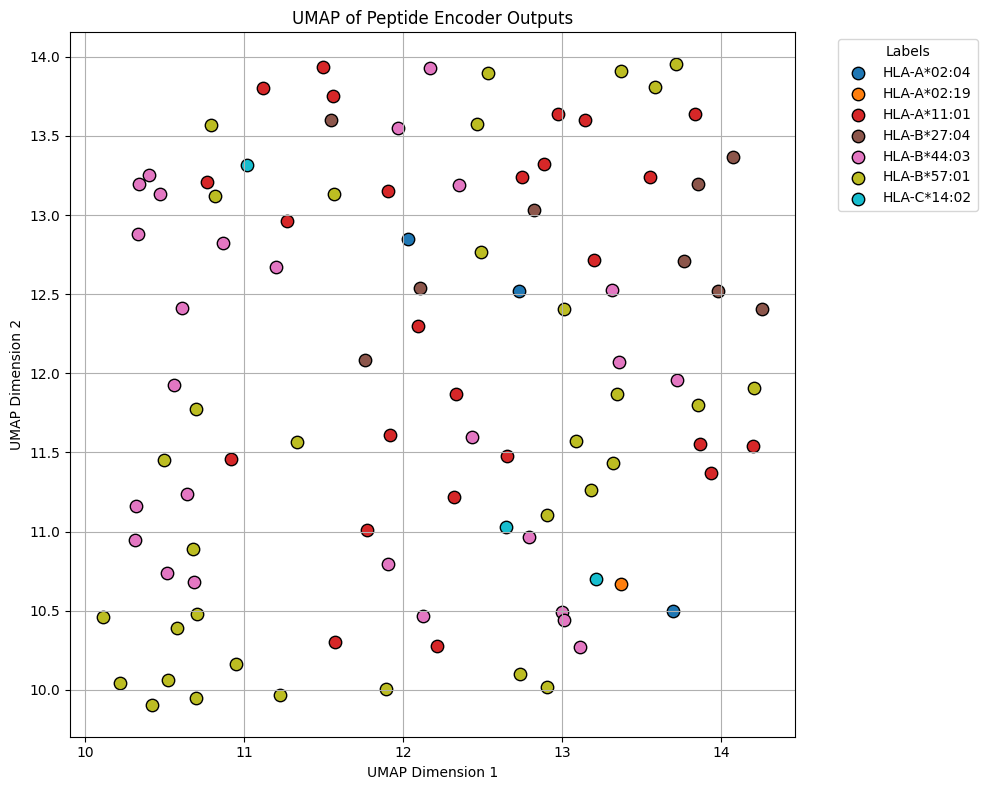

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Needed for 3D projection
import umap

def plot_umap_3d(embeddings, labels=None, title="3D UMAP of Peptide Encoder Outputs"):
    reducer = umap.UMAP(n_components=3, random_state=42)
    X_3d = reducer.fit_transform(embeddings)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    if labels is not None:
        unique_labels = np.unique(labels)
        colors = plt.cm.get_cmap('tab10', len(unique_labels))

        for i, ulab in enumerate(unique_labels):
            idx = np.array(labels) == ulab
            ax.scatter(X_3d[idx, 0], X_3d[idx, 1], X_3d[idx, 2],
                       label=ulab, color=colors(i), edgecolor='k', s=60)

        ax.legend(title="Labels", bbox_to_anchor=(1.05, 1), loc='upper left')
    else:
        ax.scatter(X_3d[:, 0], X_3d[:, 1], X_3d[:, 2], c='cornflowerblue', edgecolor='k', s=60)

    ax.set_xlabel("UMAP Dimension 1")
    ax.set_ylabel("UMAP Dimension 2")
    ax.set_zlabel("UMAP Dimension 3")
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Apply mean pooling across peptide sequence positions
pooled = pepEncoderOutputs.mean(dim=1).cpu().numpy()  # shape: [batch_size, d_model]
plot_umap_3d(pooled, labelsSmallHla)
